<a href="https://colab.research.google.com/github/ZizZu94/nlu-second-assignment/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[NLU] Second Assignment** 
*   **Zihadul Azam**
*   Id: 221747
*   zihadul.azam@studenti.unitn.it




# **Requirements**


*   SpaCy: run `pip install spacy`
*   Numpy: run `pip install numpy`
*   Pandas: run `pip install pandas`

In [93]:
import re
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import Doc, Span
import conll

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from collections import defaultdict

# **Load Data and Pre-processing**

Load pre-trained language model and set **White-space tokenizer**.

Spacy default tokenizer is not good for Conll2003 data set. For example if the input is `+33456` spacy tokenize this string in two tokens: `+` and `33456`, but Conll2003 data set see this as one whole token: `+33456`.
So White-space tokenizer was needed.

In [94]:
nlp = spacy.load('en')

class WhitespaceTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(" ")
        return Doc(self.vocab, words=words)

# set tokenizer
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

#### **Global vars**

Conll2003 data set files path

In [95]:
data_folder_path = './data'
train_path = data_folder_path + '/train.txt'
test_path = data_folder_path + '/test.txt'

#### **Load input data**
Load **Conll2003** data set from the file and pre-process.

Here we read data from the input file and store them into a dictionary. For every sentence we store only the tokens and respective `entity` with `IOB`

In [96]:
def load_conll_file(path):
    OUTPUT_DATA = []
    # open file
    with open(path, 'r', encoding='utf-8') as f:
        data = f.read()
    sentences = data.split('\n\n')
    for sent in sentences:
        sentence = []
        ents = []
        tokens = sent.split('\n')

        if tokens[0] != '-DOCSTART- -X- -X- O' and tokens[0] != '':
            for x in tokens:
                x_split = x.split()
                # if not short length
                if len(x) > 0 and len(x_split) >= 3:
                    word = x_split[0].strip()
                    if len(word) > 0:
                        sentence.append(word)
                        try:
                            ent = x_split[-1] #get ent
                        except IndexError:
                            print('Index Error: ', x_split)
                        ents.append((word, ent)) # append word with its ent

            processed_sentence = ' '.join(sentence)
            OUTPUT_DATA.append((processed_sentence, {'entities': ents}))

    print('Done getting data !')
    print('There are %d sentences.' % (len(sentences)))
    return OUTPUT_DATA

In [97]:
# load conll2003 test data
conll_test_data = load_conll_file(test_path)

print('\n')
print('----- Sample data: first 2 sentences -----')
for k in conll_test_data[:2]:
    print('Sentence: ', k[0])
    print('Entities:')
    for e in k[1]['entities']:
        print(e[0], '|', e[1])

    print('************************************')

Done getting data !
There are 3685 sentences.


----- Sample data: first 2 sentences -----
Sentence:  SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Entities:
SOCCER | O
- | O
JAPAN | B-LOC
GET | O
LUCKY | O
WIN | O
, | O
CHINA | B-PER
IN | O
SURPRISE | O
DEFEAT | O
. | O
************************************
Sentence:  Nadim Ladki
Entities:
Nadim | B-PER
Ladki | I-PER
************************************


**Mapper**

Spacy entity tags are different w.r.t to Conll2003 tags. Moreover, Conll2003 data set has only 4 types of entity: `ORG, LOC, PER, MISC`.

So we need a mapper to map Spacy entity to Conll2003 entity, if we want to compare them and evaluate them.

In [98]:
def convert_spacy_entity_to_conll(iob, type):
    mapper = {
        'PERSON': 'PER',
        'NORP': 'MISC',
        'FAC': 'MISC',
        'ORG': 'ORG',
        'GPE': 'LOC',
        'LOC': 'LOC',
        'PRODUCT': 'MISC',
        'EVENT': 'MISC',
        'WORK_OF_ART': 'MISC',
        'LAW': 'MISC',
        'LANGUAGE': 'MISC'
    }

    if not type in mapper:
        return 'O'
    return iob + '-' + mapper[type]

This function for each sentence returns **real entities** and **predicted entities** (with IOB).

In [99]:
def get_refs_hyps(data):
    refs = [] # real entity from Conll2003 data set
    hyps = [] # hypothesis/predicted entity using Spacy

    for sent in data:
        # get entities of this sentence
        entities = sent[1]['entities']
        hyp = [] # hypothesis/predicted entity list of the sentence
        
        doc = nlp(sent[0])
        for token in doc:
          # get predicted entity
          conll_entity = convert_spacy_entity_to_conll(
                token.ent_iob_, token.ent_type_)
          # add predicted entity to the list
          hyp.append((token.text, conll_entity))

        # add real entities of this sentence
        sent_refs = [(entity[0], entity[1]) for entity in entities]
        refs.append(sent_refs)
        # add predicted entities of this sentence
        hyps.append(hyp)
    return refs, hyps

In [100]:
print('----- Sample get_refs_hyps(data): first 2 sentences -----')
test_refs, test_hyps = get_refs_hyps(conll_test_data[:2])
print("--> refs list:")
print(*test_refs, sep='\n')
print('\n')
print("--> hyps list:")
print(*test_hyps, sep='\n')

----- Sample get_refs_hyps(data): first 2 sentences -----
--> refs list:
[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'O'), (',', 'O'), ('CHINA', 'B-PER'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')]
[('Nadim', 'B-PER'), ('Ladki', 'I-PER')]


--> hyps list:
[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'O'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'B-ORG'), (',', 'O'), ('CHINA', 'B-LOC'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')]
[('Nadim', 'O'), ('Ladki', 'O')]


We can see here that the Spacy entitis have been converted correctly and we can see already that they don't match always:
* Refs list has: `('JAPAN', 'B-LOC')`
* Hyps list has: `('JAPAN', 'O')`

# **Task 1** Evaluate spaCy NER on CoNLL 2003 data (provided)

* report token-level performance (per class and total)
 * accuracy of correctly recognizing all tokens that belong to named entities (i.e. tag-level accuracy)
* report CoNLL chunk-level performance (per class and total);
 * precision, recall, f-measure of correctly recognizing all the named entities in a chunk per class and total 

> ## **Task 1.1** Report token-level performance (per class and total)
Accuracy of correctly recognizing all tokens that belong to named entities (i.e. tag-level accuracy)



In [101]:
# get refs and hyps list of the file Conll2003 Test
refs, hyps = get_refs_hyps(conll_test_data)

Get confusion matrix using scikit-learn metrics `confusion_matrix` function

* First we have to create two lists: one with all real entity values and other with predicted entity values

* Then we feed these two flat lists to the `confusion_matrix` function of scikit-learn

In [102]:
# create flat real values and predicted values lists
entity_refs = []
for sent in refs:
    for token in sent:
        entity_refs.append(token[1])

entity_hyps = []
for sent in hyps:
    for token in sent:
        entity_hyps.append(token[1])

# get confusion_matrix
labels = np.unique(entity_refs)
conf_mat = confusion_matrix(entity_refs, entity_hyps, labels=labels)
# print confusion matrix
pd_table = pd.DataFrame(conf_mat, index=labels, columns=labels)
display(pd_table)

,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O
B-LOC,1129,30,143,52,26,2,40,6,240
B-MISC,19,396,48,23,2,26,13,1,174
B-ORG,178,36,558,150,0,2,94,24,619
B-PER,50,28,168,989,0,1,25,49,307
I-LOC,3,0,0,0,130,5,50,7,62
I-MISC,0,6,4,1,8,94,34,6,63
I-ORG,11,4,6,4,33,17,464,99,197
I-PER,1,0,2,7,20,9,80,887,150
O,53,64,189,63,32,46,279,163,37434


Calculate accuracy per class and overall accuracy

$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$

In [103]:
def get_accuracy_per_class(confusion_matrix, class_labels):
  """
  this function takes confusion matrix and class names as input
  returns a dict with accuracy per class
  """
  class_accuracies = {}

  # Calculate the accuracy for each one of our classes
  for idx, cls in enumerate(class_labels):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(confusion_matrix, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current class that were predicted as such
    true_positives = confusion_matrix[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    class_accuracies[cls] = (true_positives + true_negatives) / np.sum(confusion_matrix)
  return class_accuracies

Print accuracy per class

In [104]:
# get accuracy per class
accuracies_per_clas = get_accuracy_per_class(conf_mat, labels)
# print accuracy per class
accuracy_pd_table = pd.DataFrame().from_dict(accuracies_per_clas, orient='index')
accuracy_pd_table.columns = ['Accuracy']
display(accuracy_pd_table.round(3))

# print overall accuracy (sum_accurecies_all_classes / num_classes), simple mean of all classes
overall_acc = (np.sum(accuracy_pd_table) / len(accuracy_pd_table))
print('\n')
print('> Overall accuracy: {}'.format(np.format_float_positional(overall_acc, 3)))
print('> Overall accuracy in percentage: {} %'.format(np.format_float_positional(overall_acc*100, 3)))

,Accuracy
B-LOC,0.982
B-MISC,0.990
B-ORG,0.964
B-PER,0.980
I-LOC,0.995
I-MISC,0.995
I-ORG,0.979
I-PER,0.987
O,0.942




> Overall accuracy: 0.979
> Overall accuracy in percentage: 97.916 %


> **Extra:** other metrices using sci-kit learn `classification_report`

In [105]:
class_report = classification_report(entity_refs, entity_hyps, target_names=labels, output_dict=True)
# print confusion matrix
pd_table = pd.DataFrame(class_report)
display(pd_table.round(3))

,B-LOC,B-MISC,B-ORG,B-PER,I-LOC,I-MISC,I-ORG,I-PER,O,accuracy,macro avg,weighted avg
precision,0.782,0.702,0.499,0.767,0.518,0.465,0.430,0.714,0.954,0.906,0.648,0.901
recall,0.677,0.564,0.336,0.612,0.506,0.435,0.556,0.767,0.977,0.906,0.603,0.906
f1-score,0.726,0.626,0.402,0.681,0.512,0.450,0.485,0.740,0.965,0.906,0.621,0.902
support,1668.000,702.000,1661.000,1617.000,257.000,216.000,835.000,1156.000,38323.000,0.906,46435.000,46435.000


We can see here that the classification_report has a lower total accuracy w.r.t my Overall accuracy calculated above.

I think they are different metrices, **Scikit Learn classification report**  contains the simple accuracy, which does not consider **TN** cases:
* classification report accuracy = $\frac{TP}{TP+TN+FP+FN}$

So to test, this time I calculated accuracy without considering **TN**, from my confusion matrix:

In [106]:
total_predictions = conf_mat.sum().sum()
total_correct_pred = np.diag(conf_mat).sum() # sum of the diagonal of the confusion matrix is equal to TP
test_accuracy = total_correct_pred / total_predictions

print('Total predictions: ', total_predictions)
print('Correct predictions: ', total_correct_pred)
print('Accuracy (Correct predictions / Total predictions): ', test_accuracy)

Total predictions:  46435
Correct predictions:  42081
Accuracy (Correct predictions / Total predictions):  0.9062345213739637


Here we can see that, my hypothesis was right.
So, **Scikit Learn classification report** calculate the simple accuracy, without considering **TN**

> ## **Task 1.1** Report CoNLL chunk-level performance (per class and total);
Precision, recall, f-measure of correctly recognizing all the named entities in a chunk per class and total

Here we use the evaluate function of the provided `conll.py` file to evaluate chunk-level performance

In [107]:
accuracy = conll.evaluate(refs, hyps)

table = pd.DataFrame().from_dict(accuracy, orient='index')
display(table.round(3))

,p,r,f,s
ORG,0.441,0.297,0.355,1661
PER,0.724,0.577,0.642,1617
LOC,0.771,0.668,0.716,1668
MISC,0.681,0.547,0.607,702
total,0.662,0.518,0.581,5648


# **Task 2**: Grouping of Entities
Write a function to group recognized named entities using noun_chunks method of spaCy. Analyze the groups in terms of most frequent combinations (i.e. NER types that go together).

In [108]:
def get_tokens_indexes(token_list):
  """
    this function returns the unique set of tokens id
  """
  return set([tok.i for tok in token_list])

This function returns Groups of entities (GOE) of a sentence, the input of the function is a `doc `object, created from a sentence

In [109]:
def get_doc_GOE(doc: spacy.tokens.Doc):
  """
    this function takes a doc as input
    returns list of entities groups of Doc
  """
  # entity list of each chunk (if has any)
  chunk_ents_list = defaultdict(lambda:[])
  unassigned = []

  for ent in doc.ents:
    ent_indexes = get_tokens_indexes(ent) # all token ids of the entity
    found = False

    # check if this ent is part of a chunk
    for i, chunk in enumerate(doc.noun_chunks):
      chunk_indexs = get_tokens_indexes(chunk) # all token ids of the chunk
      
      # if any token of the entity is part of the noun chunk
      if len(ent_indexes.intersection(chunk_indexs)) > 0:
        chunk_ents_list[i].append(ent[0].ent_type_)
        found = True

    # if this ent is not part of a chunk add to the unassigned list
    # so, this ent does not create any group with multiple ents,
    # it creates a group alone
    if not found:
      unassigned.append(ent[0].ent_type_)

  # join chunk_ents_list and unassigned list togather and return
  return [ents for _, ents in chunk_ents_list.items()] + [[u] for u in unassigned]

Combine all entity groups of all sentences and show the frequency for each group

In [110]:
def grouping_of_entities_freq(data):
  """
    this function takes a corpus as input
    return frequency of all groups of entities
  """
  # init result list
  result = defaultdict(lambda:0)

  for sent in data:
      doc = nlp(sent[0])
      # get doc group of entities (GOE)
      doc_GOE = get_doc_GOE(doc)
      # update frequencies in result dictionary
      for group in doc_GOE:
        result['-'.join(group)] += 1
  return result

# get frequency of groups
group_entities_frequency = grouping_of_entities_freq(conll_test_data)
# sort by frequency (most frequent on the top)
group_entities_frequency = dict(sorted(group_entities_frequency.items(), key=lambda item: item[1], reverse=True))

Print top 40 frequent groups

In [111]:
print('----- Grouping of Entities frequency (top 40) -----')
for key, value in list(group_entities_frequency.items())[:40]:
  print(key, ': ', value)

----- Grouping of Entities frequency (top 40) -----
CARDINAL :  1821
GPE :  1267
PERSON :  1050
ORG :  1043
DATE :  953
NORP :  302
MONEY :  148
ORDINAL :  115
TIME :  104
CARDINAL-PERSON :  91
PERCENT :  87
QUANTITY :  81
EVENT :  64
LOC :  53
NORP-PERSON :  45
PRODUCT :  29
ORG-PERSON :  28
GPE-PERSON :  25
CARDINAL-ORG :  21
FAC :  19
CARDINAL-GPE :  18
CARDINAL-NORP :  17
PERSON-PERSON :  13
WORK_OF_ART :  13
GPE-ORG :  11
PERSON-GPE :  10
LAW :  10
DATE-EVENT :  9
ORG-ORG :  9
GPE-GPE :  9
LANGUAGE :  7
NORP-ORG :  6
ORG-GPE :  5
DATE-ORG :  5
DATE-TIME :  5
DATE-NORP :  5
ORG-DATE :  5
DATE-PERSON :  3
PERSON-ORG :  3
GPE-ORDINAL :  3


**Extra test**: calculate frequency by class number of group

> example: `"CARDINAL-NORP"` is built with 2 classes or entities

In [112]:
class_num_freq = defaultdict(lambda:0)
for key, value in group_entities_frequency.items():
  classes = key.split('-')
  class_num_freq[len(classes)] += value

print('----- Frequency by number of classes -----')
for key, value in class_num_freq.items():
  print('Group with ', key, ' class: ', value)

----- Frequency by number of classes -----
Group with  1  class:  7166
Group with  2  class:  405
Group with  3  class:  20
Group with  4  class:  3


Here we can see that, the group with 1 entity/class is most frequent and only 3 entries for group made by 4 classes

# **Task 3**: Post-processing 
Write a function that extends the entity span to cover the full noun-compounds. Make use of `compound` dependency relation.

Here the idea is:
* for each `entity` of the `doc`, take it's `token list`
 * then for each `token` (from `token list`) take his `children` and `parent`, We called them togather `family members`
   * If a family member has `compund` dependency and empty `entity type`
     * Then check if we can extend the `entity type` from the `parent` (if fam member is a children) or from the `child` (if fam member is parent) 

In [113]:
def extend_entities(token_list, start, end, ent_type):
  """
  this function update ent_type,
  start token has B-ent_type
  and rest I-ent_type
  """
  iob = 'B'
  for i in range(start, end):
      new_ent = convert_spacy_entity_to_conll(iob, ent_type)
      text = token_list[i][0] 
      token_list[i] = (text, new_ent)
      if iob == 'B':
        iob = 'I'
  return token_list

def post_processing(doc: spacy.tokens.Doc):
  total_changes = 0
  result = {}
  # init result list
  for token in doc:
    result[token.i] = (token.text, convert_spacy_entity_to_conll(token.ent_iob_, token.ent_type_))
  
  # contains ents already processed
  already_processed = []

  for ent in doc.ents:
    # create ent token list, so can be modified this list
    ent_token_list = list(ent)
    for ent_token in ent_token_list:
      # we want to extend the entity to the children and also to the parent
      # in both case they can have a compund dependency with this entity
      # but without entity for itself,
      # so we take as candidate all children
      # and also the parent if current entity has dep_ == compound
      family_list = list(ent_token.children) + ([ent_token.head] if ent_token.dep_ == 'compund' and ent_token.head.ent_type_ == '' else []) 
      for fam_member in family_list:
        # check if this member is a neighbour
        is_neighbour = fam_member.i == ent.start - 1 or fam_member.i == ent.end
        # check if this member has compound dep and has empty ent and is neighbour and yet not pre processed      
        if fam_member.dep_ == 'compound' and fam_member.ent_type_ == '' and is_neighbour and not fam_member.i in already_processed:
          # find start and finish of the current ent 
          start = min(fam_member.i, ent.start)
          end = max(fam_member.i, ent.end)
          # extend ent and save into the result list
          result = extend_entities(result, start, end, ent_token.ent_type_)
          # add this new fam_memeber to the current ent token list, so we can check if
          # it has itself any children or parent who needs entity extend
          ent_token_list.append(fam_member)
          # update count
          total_changes += 1
          # add to already_processed list
          already_processed.append(fam_member.i)

  return total_changes, [value for _,value in result.items()]

**Test:** doing test with a single sentence

In [114]:
test = "He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains"
doc = nlp(test)
total_changes, result = post_processing(doc)

print('------------ Test result -------------')
print('Sentence: ', test)
print('Text', ' '*(8) ,'Iob-Ent\tPost-proces')
for token in doc:
  iob_ent = convert_spacy_entity_to_conll(token.ent_iob_, token.ent_type_)
  print(token.text, ' '*(15-len(token.text)) , iob_ent, '\t', result[token.i][1])

print('Total entity changes: ', total_changes)
print('Note: Commissioner\'s ent type has been changed')

------------ Test result -------------
Sentence:  He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains
Text          Iob-Ent	Post-proces
He               O 	 O
said             O 	 O
a                O 	 O
proposal         O 	 O
last             O 	 O
month            O 	 O
by               O 	 O
EU               B-ORG 	 B-ORG
Farm             I-ORG 	 I-ORG
Commissioner     O 	 B-PER
Franz            B-PER 	 I-PER
Fischler         I-PER 	 I-PER
to               O 	 O
ban              O 	 O
sheep            O 	 O
brains           O 	 O
Total entity changes:  1
Note: Commissioner's ent type has been changed


In [115]:
post_processing_result = []
total_changes = 0

for sent in conll_test_data:
  doc = nlp(sent[0])
  t, res = post_processing(doc)
  post_processing_result.append(res)
  total_changes += t

print('Total entity changes: ', total_changes)

Total entity changes:  344


In [116]:
accuracy = conll.evaluate(refs, post_processing_result)

table = pd.DataFrame().from_dict(accuracy, orient='index')
display(table.round(3))

,p,r,f,s
ORG,0.428,0.288,0.345,1661
PER,0.585,0.466,0.519,1617
LOC,0.754,0.653,0.700,1668
MISC,0.679,0.546,0.605,702
total,0.613,0.479,0.538,5648


Here we can see that, the performances is slightly gone down.

Before post-processing the performance was:

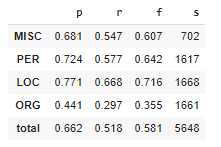